# Notebook Imports

In [1]:
from os import walk
from os.path import join
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [2]:
#dataset----- spam assassin public corpus

EXAMPLE_FILE='SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE=2500

DATA_JSON_FILE='SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE='SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE='SpamData/02_Training/train-data.txt'
TEST_DATA_FILE='SpamData/02_Training/test-data.txt'



WHALE_FILE='SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE='SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE='SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE='SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'


# Reading Files

In [3]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
message=stream.read()
stream.close()
print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [5]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True
stream.close()
email_body='\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Genarator Function

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number**2

In [7]:
for i in generate_squares(4):
    print(i,end='->')

0->1->4->9->

# Email Body Extraction

In [8]:
def email_body_generator(path):
    for root , dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath=join(root, file_name)
            stream=open(filepath,encoding='latin-1')
            is_body=False
            lines=[]
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True
            stream.close()
            email_body='\n'.join(lines)

            yield file_name, email_body

In [9]:
def df_from_directory(path,classification):
    rows=[]
    row_names=[]
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails=df_from_directory(SPAM_1_PATH,1)
spam_emails=spam_emails.append(df_from_directory(SPAM_2_PATH,1))
spam_emails.head()

CATEGORY  \
00001.7848dde101aa985090474a91ec93fcf0         1   
00002.d94f1b97e48ed3b553b3508d116e6a09         1   
00003.2ee33bc6eacdb11f38d052c44819ba6c         1   
00004.eac8de8d759b7e74154f142194282724         1   
00005.57696a39d7d84318ce497886896bf90d         1   

                                                                                  MESSAGE  
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...  
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00004.eac8de8d759b7e74154f142194282724  ##############################################...  
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...

In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails=df_from_directory(EASY_NONSPAM_1_PATH,0)
ham_emails=ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
ham_emails.head()

CATEGORY  \
00001.7c53336b37003a9286aba55d2945844c         0   
00002.9c4069e25e1ef370c078db7ee85ff9ac         0   
00003.860e3c3cee1b42ead714c5c874fe25f7         0   
00004.864220c5b6930b209cc287c361c99af1         0   
00005.bf27cdeaf0b8c4647ecd61b1d09da613         0   

                                                                                  MESSAGE  
00001.7c53336b37003a9286aba55d2945844c      Date:        Wed, 21 Aug 2002 10:54:46 -05...  
00002.9c4069e25e1ef370c078db7ee85ff9ac  Martin A posted:\n\nTassos Papadopoulos, the G...  
00003.860e3c3cee1b42ead714c5c874fe25f7  Man Threatens Explosion In Moscow \n\n\n\nThur...  
00004.864220c5b6930b209cc287c361c99af1  Klez: The Virus That Won't Die\n\n \n\nAlready...  
00005.bf27cdeaf0b8c4647ecd61b1d09da613  >  in adding cream to spaghetti carbonara, whi...

In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data=pd.concat([spam_emails,ham_emails])
print('Shape of entire dataframe',data.shape)
data.head()

Shape of entire dataframe (5799, 2)


CATEGORY  \
00001.7848dde101aa985090474a91ec93fcf0         1   
00002.d94f1b97e48ed3b553b3508d116e6a09         1   
00003.2ee33bc6eacdb11f38d052c44819ba6c         1   
00004.eac8de8d759b7e74154f142194282724         1   
00005.57696a39d7d84318ce497886896bf90d         1   

                                                                                  MESSAGE  
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...  
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...  
00004.eac8de8d759b7e74154f142194282724  ##############################################...  
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...

In [15]:
data.tail()

CATEGORY  \
01396.61983fbe6ec43f55fd44e30fce24ffa6         0   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0   
01398.169b51731fe569f42169ae8f948ec676         0   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0   
01400.f897f0931e461e7b2e964d28e927c35e         0   

                                                                                  MESSAGE  
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...  
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...  
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...

# Data Cleaning : Checking for missing values

In [16]:
# check ifany message bodies are null 
data['MESSAGE'].isnull().values.any()

False

In [17]:
type('')

str

In [18]:
len('')

0

In [19]:
my_var=None
type(my_var)

NoneType

In [20]:
# Check if any email is empty(string length equaul to 0)
(data['MESSAGE'].str.len()==0).values.any()

True

In [21]:
(data['MESSAGE'].str.len()==0).sum()

3

In [22]:
# how could you email which contain None value
data['MESSAGE'].isnull().sum()

0

### Locate the empty email

In [23]:
data[data['MESSAGE'].str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [25]:
data[4608:4611]

CATEGORY  \
00210.ca401834d76bbedb98e548160e2ab559         0   
00211.835ec23b746b6aede4e2e15ced421bb4         0   
00212.df5211161d938a2547804a50f0a8698f         0   

                                                                                  MESSAGE  
00210.ca401834d76bbedb98e548160e2ab559  I have a strange problem with one user in a sm...  
00211.835ec23b746b6aede4e2e15ced421bb4  I just heard from Kevin Patrick Scannell, auth...  
00212.df5211161d938a2547804a50f0a8698f  At 17:34 31/07/02 +0100, Liam Bedford wrote:\n...

# Remove System File Entries from Dataframe

In [26]:
#data=data.drop(['cmds'])
data.drop(['cmds'],inplace=True)

In [27]:
data.shape

(5796, 2)

# Add Document IDs to track email in dataframe

In [28]:
document_ids=range(0,len(data.index))
data['DOC_ID']=document_ids
data.DOC_ID

00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
00006.5ab5620d3d7c6c0db76234556a16f6c1       5
00007.d8521faf753ff9ee989122f6816f87d7       6
00008.dfd941deb10f5eed78b1594b131c9266       7
00009.027bf6e0b0c4ab34db3ce0ea4bf2edab       8
00010.445affef4c70feec58f9198cfbc22997       9
00011.61816b9ad167657773a427d890d0468e      10
00012.381e4f512915109ba1e0853a7a8407b2      11
00013.d3f0b591a65f116ea5d9d4ad919f83aa      12
00014.7d38c46424f24fc8012ac15a95a2ac14      13
00015.048434ab64c86cf890eda1326a5643f5      14
00016.67fb281761ca1051a22ec3f21917e7c0      15
00017.1a938ecddd047b93cbd7ed92c241e6d1      16
00018.5b2765c42b7648d41c93b9b27140b23a      17
00019.bbc97ad616ffd06e93ce0f821ca8c381      18
00020.29725cf331fc21e18a1809e7d8b27332      19
00021.effe1449462a9d7ad7af0f1c94b1a237      20
00022.8203cdf

In [29]:
data['FILE_NAME']=data.index
data.set_index('DOC_ID',inplace=True)
data.head()

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
2              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
3              1  ##############################################...   
4              1  I thought you might like these:\n\n1) Slim Dow...   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [30]:
data.tail()

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
5791           0  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
5792           0  > >-- be careful when using this one.) Also, t...   
5793           0  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
5794           0  So then, "Mark Hammond" <mhammond@skippinet.co...   
5795           0  Hi there,\n\n\n\nNow this is probably of no us...   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

# Save File using Pandas

In [31]:
data.to_json(DATA_JSON_FILE)

# Number of spam message Visualised(pie Charts)

In [32]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [33]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_ham=data.CATEGORY.value_counts()[0]

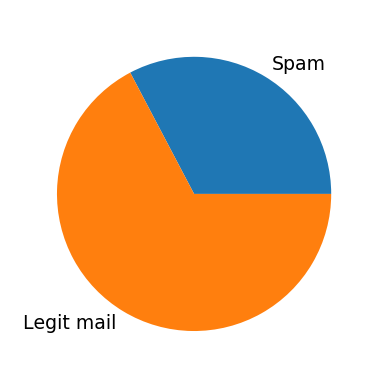

In [34]:
category_names=['Spam','Legit mail']
sizes=[amount_of_spam, amount_of_ham]


plt.figure(figsize=[2,2],dpi=227)
plt.pie(sizes,labels=category_names, textprops={'fontsize':6})
plt.show()

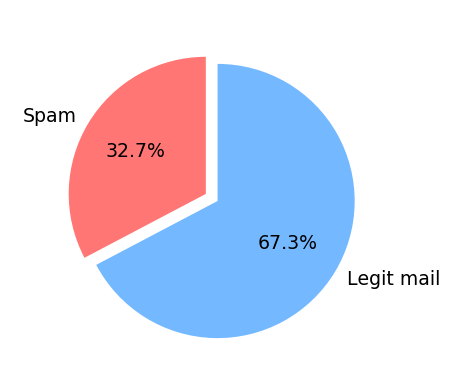

In [35]:
category_names=['Spam','Legit mail']
sizes=[amount_of_spam, amount_of_ham]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=[2,2],dpi=227)
plt.pie(sizes,labels=category_names, textprops={'fontsize':6}, startangle=90 ,autopct='%1.1f%%',
       colors=custom_colors,explode=[0,0.1])
plt.show()

# Natural Language Processing

## Text Pre-processing

In [38]:
msg='All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

## Download the NLTK Resource (Tokenize and Stopwords)

In [39]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [40]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

## Tokenising

In [42]:
msg='All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

In [43]:
stop_words= set(stopwords.words('english'))

In [44]:
type(stop_words)

set

In [45]:
if 'hello' not in stop_words:print('Nope!not in there')

Nope!not in there


In [46]:
msg='All work an no play makes Jack a dull boy. To be or not to be.'
words =word_tokenize(msg.lower())

filtered_words=[]
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems and Stemming

In [47]:
msg='All work an no play makes Jack a dull boy. To be or not to be. \
Nobody expects Spanish Inquisition???'
words =word_tokenize(msg.lower())

stemmer= PorterStemmer()
#stemmer=SnowballStemmer('english')
filtered_words=[]
for word in words:
    if word not in stop_words:
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '?', '?', '?']


## Removing Punctuation

In [48]:
'?'.isalpha()

False

In [49]:
'pp'.isalpha()

True

In [50]:
msg='All work an no play makes Jack a dull boy. To be or not to be. \
Nobody expects Spanish Inquisition???'
words =word_tokenize(msg.lower())


stemmer=SnowballStemmer('english')
filtered_words=[]
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word=stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [51]:
data.at[7,'MESSAGE']

'<html>\n\n<head>\n\n<title>ReliaQuote - Save Up To 70% On Life Insurance</title>\n\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1">\n\n</head>\n\n<body leftmargin="0" topmargin="0" link="#FFCC99" vlink="#FFCC99" alink="#FFCC00">\n\n<table align="center" width="468" border="0" cellspacing="0" cellpadding="0" height="500" bgcolor="993366">\n\n  <tr>\n\n    <td align="left" valign="top" height="43" width="56%">\n\n      <table width="100%" border="0" cellspacing="0" cellpadding="3">\n\n        <tr>\n\n          <td><a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&ext=1" target="_blank"><img src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120" height="32" border="0"></a></td>\n\n        </tr>\n\n      </table>\n\n    </td>\n\n    <td align="left" valign="top" height="43" width="44%">&nbsp;</td>\n\n  </tr>\n\n  <tr>\n\n    <td align="left" valign="top" width="56%" height="377">\n\n      <table width="100%" border="0" cellsp

## Removing HTML Tag from email

In [52]:
soup=BeautifulSoup(data.at[7,'MESSAGE'], 'html.parser')
print(soup.prettify())

<html>
 <head>
  <title>
   ReliaQuote - Save Up To 70% On Life Insurance
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
 </head>
 <body alink="#FFCC00" leftmargin="0" link="#FFCC99" topmargin="0" vlink="#FFCC99">
  <table align="center" bgcolor="993366" border="0" cellpadding="0" cellspacing="0" height="500" width="468">
   <tr>
    <td align="left" height="43" valign="top" width="56%">
     <table border="0" cellpadding="3" cellspacing="0" width="100%">
      <tr>
       <td>
        <a href="http://theadmanager.com/server/c.asp?ad_key=YUESBHWAKMLK&amp;ext=1" target="_blank">
         <img border="0" height="32" src="http://www.reliaquote.com/banner/bannerads/images/logo6.gif" width="120"/>
        </a>
       </td>
      </tr>
     </table>
    </td>
    <td align="left" height="43" valign="top" width="44%">
    </td>
   </tr>
   <tr>
    <td align="left" height="377" valign="top" width="56%">
     <table border="0" cellpadding="0" cellspacing="0" 

In [53]:
soup.get_text()

"\n\nReliaQuote - Save Up To 70% On Life Insurance\n\n\n\n\n\n\n\n\n\n\n\n\n\xa0\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLife\n\n                                can change in an instant. That's why it is so\n\n                                important to protect your family's financial future\n\n                                with sufficient life insurance coverage.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nState\n\n                          of Residence:\n\n\n\nSelect State\nAlabama\nAlaska\nArizona\nArkansas\nCalifornia\nColorado\nConnecticut\nDelaware\nDist. of Columbia\nFlorida\nGeorgia\nHawaii\nIdaho\nIllinois\nIndiana\nIowa\nKansas\nKentucky\nLouisiana\nMaine\nMaryland\nMassachusetts\nMichigan\nMinnesota\nMississippi\nMissouri\nMontana\nNebraska\nNevada\nNew Hampshire\nNew Jersey\nNew Mexico\nNew York\nNorth Carolina\nNorth Dakota\nOhio\nOklahoma\nOregon\nPennsylvania\nRhode Island\nSouth Carolina\nSouth Dakota\nTennessee\nTexas\nUtah\nVermont\nVirginia\nWashington\nWest V

# Function for Email Processing

In [54]:
def clean_message(message, stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    # Conert to lower case and split the words
    words=word_tokenize(message.lower())
    filtered_words=[]
    
    for word in words:
        # Remove punctuation and stopwords
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [55]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [56]:
# Remove HTML tag and apply on number 7 message
def clean_msg_no_html(message, stemmer=PorterStemmer(),stop_words=set(stopwords.words('english'))):
    # Convert to lower case and split the words
    soup=BeautifulSoup(message, 'html.parser')
    clean_text=soup.get_text()
    words=word_tokenize(clean_text.lower())
    #words=word_tokenize(clean_text.upper())
    filtered_words=[]
    
    for word in words:
        # Remove punctuation and stopwords
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
            
    return filtered_words

In [57]:
clean_msg_no_html(data.at[7,'MESSAGE'])

['reliaquot',
 'save',
 'life',
 'insur',
 'life',
 'chang',
 'instant',
 'import',
 'protect',
 'famili',
 'financi',
 'futur',
 'suffici',
 'life',
 'insur',
 'coverag',
 'state',
 'resid',
 'select',
 'state',
 'alabama',
 'alaska',
 'arizona',
 'arkansa',
 'california',
 'colorado',
 'connecticut',
 'delawar',
 'dist',
 'columbia',
 'florida',
 'georgia',
 'hawaii',
 'idaho',
 'illinoi',
 'indiana',
 'iowa',
 'kansa',
 'kentucki',
 'louisiana',
 'main',
 'maryland',
 'massachusett',
 'michigan',
 'minnesota',
 'mississippi',
 'missouri',
 'montana',
 'nebraska',
 'nevada',
 'new',
 'hampshir',
 'new',
 'jersey',
 'new',
 'mexico',
 'new',
 'york',
 'north',
 'carolina',
 'north',
 'dakota',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'rhode',
 'island',
 'south',
 'carolina',
 'south',
 'dakota',
 'tennesse',
 'texa',
 'utah',
 'vermont',
 'virginia',
 'washington',
 'west',
 'virginia',
 'wisconsin',
 'wyom',
 'date',
 'birth',
 'mm',
 'dd',
 'yy',
 'sex',
 'male',
 'femal'

# Apply Cleaning and tokenization to all Messages

### Slicing DataFrames and series & creating  subsets

In [58]:
# first is row and second is column
data.iat[2,1]

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [59]:
# Select more than one value in row
data.iloc[5:11]

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
5              1  A POWERHOUSE GIFTING PROGRAM You Don't Want To...   
6              1  Help wanted.  We are a 14 year old fortune 500...   
7              1  <html>\n\n<head>\n\n<title>ReliaQuote - Save U...   
8              1  TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...   
9              1  Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...   
10             1  Cellular Phone Accessories All At Below Wholes...   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [60]:
first_emails=data.MESSAGE.iloc[0:4]
nested_list=first_emails.apply(clean_message)


In [61]:
flat_list=[]
for sublist in nested_list:
    for item in sublist:
        flat_list.append(item)
        
len(flat_list)

526

In [62]:
flat_list

['doctyp',
 'html',
 'public',
 'html',
 'html',
 'head',
 'meta',
 'ype',
 'meta',
 'mshtml',
 'bodi',
 'insert',
 'calypso',
 'tabl',
 'color',
 'black',
 'display',
 'none',
 'tbodi',
 'tr',
 'td',
 'hr',
 'noshad',
 'tr',
 'td',
 'hr',
 'noshad',
 'end',
 'calypso',
 'insert',
 'font',
 'arial',
 'helvetica',
 'br',
 'end',
 'calypso',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'save',
 'life',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'spend',
 'center',
 'font',
 'copperpl',
 'gothic',
 'bold',
 'center',
 'life',
 'quot',
 'save',
 'center',
 'p',
 'p',
 'br',
 'p',
 'center',
 'tabl',
 'tbodi',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'b',
 'font',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'tr',
 'td',
 'tabl',
 'tbodi',
 'tr',
 'td',
 'font',
 'b',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',

In [63]:
# Let me do this exact same thing by using list comprehension
flat_list=[item for sublist in nested_list for item in sublist]
len(flat_list)

526

In [64]:
%%time
# use apply() method  on all message in the DataFrame
nested_list=data.MESSAGE.apply(clean_msg_no_html)

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 1min 47s


In [65]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Using Logic to Slice DataFrame

In [66]:
data[data.CATEGORY==1].shape

(1896, 3)

In [67]:
data[data.CATEGORY==1].head()

CATEGORY                                            MESSAGE  \
DOC_ID                                                                
0              1  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
1              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
2              1  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
3              1  ##############################################...   
4              1  I thought you might like these:\n\n1) Slim Dow...   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [68]:
## To create two variabe which hold index of spam and ham message
doc_ids_spam=data[data.CATEGORY==1].index
doc_ids_ham=data[data.CATEGORY==0].index

In [69]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting series with an index

In [70]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [71]:
type(nested_list)

pandas.core.series.Series

In [72]:
nested_list_ham=nested_list.loc[doc_ids_ham]
nested_list_spam=nested_list.loc[doc_ids_spam]

In [73]:
nested_list_ham.shape

(3900,)

In [74]:
nested_list_ham.head()

DOC_ID
1896    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1897    [martin, post, tasso, papadopoulo, greek, scul...
1898    [man, threaten, explos, moscow, thursday, augu...
1899    [klez, viru, wo, die, alreadi, prolif, viru, e...
1900    [ad, cream, spaghetti, carbonara, effect, past...
Name: MESSAGE, dtype: object

In [75]:
# Use list Comprehension and then find total number of words in spam email and normal email
# and also find 10 most common word in spam email and normal email
flat_list_ham=[item for sublist_ham in nested_list_ham for item in sublist_ham]
normal_word=pd.Series(flat_list_ham)            #total number of words in non spam email
normal_words=pd.Series(flat_list_ham).value_counts()        #total number of unique words in non spam email 


print(normal_word.shape[0])
print(normal_words.shape[0])
#print(len(flat_list_spam))

441403
20755


In [76]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [77]:
flat_list_spam=[item for sublist_spam in nested_list_spam for item in sublist_spam]
spammy_words=pd.Series(flat_list_spam).value_counts() 

print(spammy_words.shape[0])
print(len(flat_list_spam))
spammy_words[:10]

13284
320571


http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating a word cloud

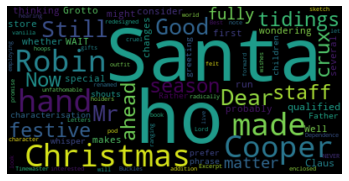

In [78]:
word_cloud=WordCloud().generate(text=email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()


In [84]:
rgb_array.shape

(1024, 2048, 3)

In [85]:
rgb_array[500,1000]         # in this area image pixel is black

array([0, 0, 0], dtype=uint8)

In [86]:
rgb_array[1023,2047]         # in this area image pixel is white

array([255, 255, 255], dtype=uint8)

# Word cloud for Spam and Ham messages

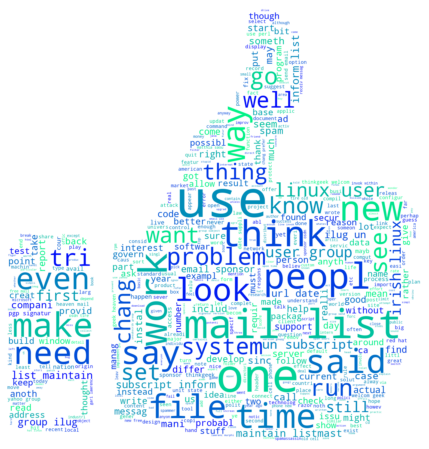

In [91]:
icon=Image.open(THUMBS_UP_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array=np.array(image_mask)     # convert image to nd-array

# Convert flat_list_ham list to text 
ham_str=' '.join(flat_list_ham)

word_cloud=WordCloud(mask=rgb_array, background_color='white',colormap='winter', max_words=500)
word_cloud.generate(text=ham_str)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()


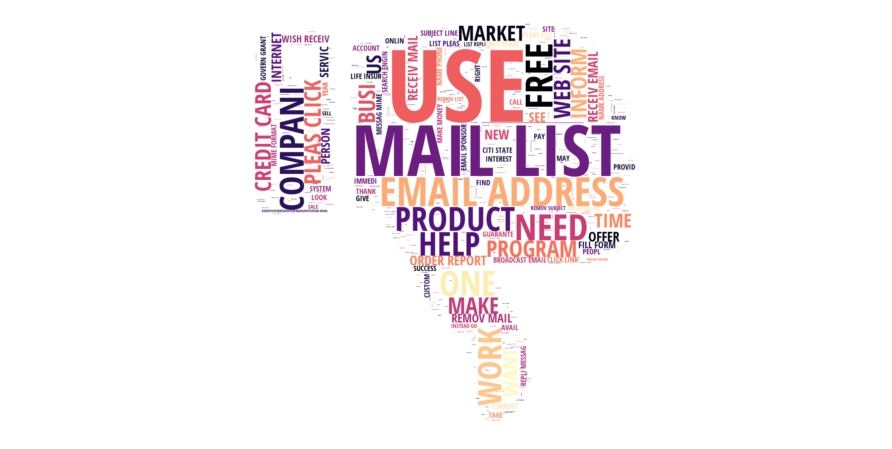

In [92]:
icon=Image.open(THUMBS_DOWN_FILE)
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)

rgb_array=np.array(image_mask)     # convert image to nd-array

# Convert flat_list_ham list to text 
spam_str=' '.join(flat_list_spam)

word_cloud=WordCloud(font_path=CUSTOM_FONT_FILE , mask=rgb_array,max_font_size=300,
                     background_color='white',colormap='magma', max_words=500)
word_cloud.generate(text=spam_str.upper())

plt.figure(figsize=(16,8))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()


# Generate Vacabulary and Dictionary

In [93]:
stemmed_nested_list=data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list=[item for sub_stemmed_list in stemmed_nested_list for item in sub_stemmed_list]


In [94]:
stemmed_nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [95]:
unique_words=pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words',unique_words.shape[0])
unique_words.head()

Number of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [96]:
# create series that contain only 2500 unique words
frequent_words=unique_words[0:VOCAB_SIZE]
print('10 word is ',frequent_words[:10])
type(frequent_words)
frequent_words.index

10 word is  http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'pleasur', 'everywher', 'freez', 'milter', 'raid', 'pci', 'angel',
       'mutual', 'rm', 'burner'],
      dtype='object', length=2500)

## Create a Vocabulary DataFrame with Word_ID

In [97]:
word_ids=list(range(0,VOCAB_SIZE))
vocab=pd.DataFrame({'VOCAB_WORD':frequent_words.index.values},index=word_ids)
vocab.index.name='WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

## Save the Vocabulary as csv File 

In [98]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Checking the word if the part of our Vocabulary

In [99]:
# Check these word = 'machine' , 'learning' , 'fun' , 
#='learn' , 'data' , 'science' , 'app' , 'brewery'
def func(word):
    if word in frequent_words.index:
        return True
    return False
print(func('data'))
print(func('machine'))
print(func('learning'))
print(func('fun'))
print(func('learn'))
print(func('data'))
print(func('science'))
print(func('app'))
print(func('brewery'))

True
False
False
True
True
True
False
True
False


In [100]:
# Another way of doing above things
any(vocab.VOCAB_WORD =='machine')      #inefficient way

False

In [101]:
'app' in set(vocab.VOCAB_WORD)

True

## Find Email with most Number of words

In [102]:
# Number of words in in maximum length email(after cleaning and stemming) ,index(position)
# stemmed list of words
# print out longest email data dataFrame
m=0
i=0
for sub_stemmed_list in stemmed_nested_list:
    if len(sub_stemmed_list)>m:
        m=len(sub_stemmed_list)
        list_of_word=sub_stemmed_list
        #result=' '.join(sub_stemmed_list)
    i+=1
print('Length of maximum len email ',m)
print('List of words',list_of_word)
print('index of maximum len email ',i)
print('email of maximum len email ',result)

Length of maximum len email  7671
List of words ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', 'filenam', 

NameError: name 'result' is not defined

In [103]:
# Another way 
clean_email_lengths=[]
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))
print(clean_email_lengths)


[92, 56, 44, 205, 45, 161, 47, 162, 202, 43, 55, 23, 44, 73, 58, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 24, 61, 94, 312, 56, 141, 72, 55, 1060, 46, 139, 2, 90, 78, 4, 47, 70, 44, 74, 38, 12, 38, 60, 47, 51, 71, 80, 25, 273, 36, 60, 19, 18, 14, 40, 57, 18, 77, 28, 102, 40, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 58, 253, 1216, 49, 0, 65, 52, 141, 15, 0, 90, 70, 2, 196, 50, 50, 50, 213, 117, 43, 80, 43, 319, 242, 9, 36, 97, 25, 52, 333, 47, 60, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 24, 129, 50, 0, 39, 74, 43, 72, 47, 157, 0, 27, 223, 97, 0, 58, 84, 213, 75, 47, 18, 166, 20, 112, 104, 187, 6, 40, 54, 79, 276, 110, 208, 6, 479, 62, 17, 175, 79, 47, 74, 80, 258, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1389, 108, 97, 23, 185, 1, 117, 258, 28, 142, 195, 177, 0, 97, 109, 1465, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 185, 77, 330, 14, 92, 92, 166, 372, 187, 241, 143, 254, 14, 97, 135, 223, 65, 90, 226, 217, 129, 38, 94, 204, 258, 215, 146

In [104]:
clean_email_lengths=[len(sublist) for sublist in stemmed_nested_list]
print('Nr of words in longest email',max(clean_email_lengths))
print(' email position in the list ( and data in dataframe)',np.argmax(clean_email_lengths))
stemmed_nested_list[np.argmax(clean_email_lengths)]

Nr of words in longest email 7671
 email position in the list ( and data in dataframe) 5775


['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [105]:
data.at[np.argmax(clean_email_lengths),'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Genrate Feature and Sparse Matrix

### Creating a DataFrame with one word per Column

In [106]:
type(stemmed_nested_list)

pandas.core.series.Series

In [107]:
type(stemmed_nested_list.tolist())

list

In [108]:
stemmed_nested_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [109]:
word_columns_df=pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

0      1       2      3           4         5       6     7       8     \
0     save   life   insur  spend        life      quot    save     g  famili   
1    fight   risk  cancer   http        slim  guarante    lose    lb     day   
2    fight   risk  cancer   http        slim  guarante    lose    lb     day   
3    adult   club   offer   free  membership   instant  access  site    user   
4  thought  might    like   slim    guarante      lose      lb   day    http   

      9     ...  7661  7662  7663  7664  7665  7666  7667  7668  7669  7670  
0  financi  ...  None  None  None  None  None  None  None  None  None  None  
1     http  ...  None  None  None  None  None  None  None  None  None  None  
2     http  ...  None  None  None  None  None  None  None  None  None  None  
3     name  ...  None  None  None  None  None  None  None  None  None  None  
4    fight  ...  None  None  None  None  None  None  None  None  None  None  

[5 rows x 7671 columns]

In [110]:
word_columns_df.shape

(5796, 7671)

## Spliting data into Training and Testing Dataset

In [111]:
# Set training and testing : and set Test size =30%
# Training data include 4057 email. seed value 42 for suffle data
# target value


In [112]:
X_train , X_test, y_train , y_test=train_test_split(word_columns_df, data.CATEGORY,
                                                    test_size=0.3, random_state=42)
# % of train data
len(X_train)/len(word_columns_df)


0.6999654934437544

In [113]:
print('Number of training dataset',len(X_train))

Number of training dataset 4057


In [114]:
X_train.index.name=X_test.index.name='DOC_ID'
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [115]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

## Creaing a Sparse Matrix for training data

In [116]:
word_index=pd.Index(vocab.VOCAB_WORD)
type(word_index[3])


str

In [117]:
word_index

Index(['http', 'use', 'list', 'email', 'get', 'mail', 'one', 'free', 'time',
       'work',
       ...
       'pleasur', 'everywher', 'freez', 'milter', 'raid', 'pci', 'angel',
       'mutual', 'rm', 'burner'],
      dtype='object', name='VOCAB_WORD', length=2500)

In [118]:
word_index.get_loc('thu')

396

In [119]:
vocab.VOCAB_WORD[395]

'bill'

In [120]:
def make_sparse_matrix(df, indexed_words, labels):
    """ 
    Return Sparse matrix as dataframe.
    
    df: A dataframe with word in a column with index is document Id ( X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: Categories as a spam (y_train or y_test)
    
    """
    nr_rows=df.shape[0]
    nr_cols=df.shape[1]
    word_sets=set(indexed_words)
    dict_list=[]
    for i in range(nr_rows):
        for j in range(nr_cols):
            word=df.iat[i,j]
            if word in word_sets:
                doc_id=df.index[i]
                word_id=indexed_words.get_loc(word)
                category=labels.at[doc_id]
                item={'LABEL':category, 'DOC_ID':doc_id, 'OCCURENCE':1, 'WORD_ID':word_id}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [121]:
%%time
sparse_train_df=make_sparse_matrix(X_train, word_index, y_train)

Wall time: 9min 46s


In [122]:
sparse_train_df[:5]

DOC_ID  LABEL  OCCURENCE  WORD_ID
0    4844      0          1      265
1    4844      0          1     1271
2    4844      0          1      508
3    4844      0          1      310
4    4844      0          1      254

In [123]:
sparse_train_df.shape

(430996, 4)

In [124]:
sparse_train_df[-5:]

DOC_ID  LABEL  OCCURENCE  WORD_ID
430991     860      1          1       47
430992     860      1          1     1436
430993     860      1          1       26
430994     860      1          1       19
430995     860      1          1      126

### Combine Occurences with pandas groupby() method

In [125]:
vocab.at[0,'VOCAB_WORD']

'http'

In [126]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [127]:
trained_group=sparse_train_df.groupby(['DOC_ID' , 'WORD_ID', 'LABEL']).sum()
trained_group.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [128]:
trained_group=trained_group.reset_index()
trained_group.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      1          1
1       0        3      1          2
2       0        4      1          1
3       0        7      1          3
4       0       11      1          1

In [129]:
trained_group.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
258347    5795     2052      0          2
258348    5795     2056      0          1
258349    5795     2289      0          1
258350    5795     2366      0          1
258351    5795     2415      0          1

In [130]:
vocab.at[2427, 'VOCAB_WORD']

'greatest'

In [131]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [132]:
trained_group.shape

(258352, 4)

### Saving Training Data  as .txt file

In [133]:
np.savetxt(TRAINING_DATA_FILE,trained_group, fmt='%d')

In [134]:
trained_group.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

### Sparse Matrix  for test data and Group the same word in same email

In [135]:
%%time
sparse_test_df=make_sparse_matrix(X_test, word_index, y_test)

Wall time: 20min


In [136]:
sparse_test_df[:5]

DOC_ID  LABEL  OCCURENCE  WORD_ID
0    4675      0          1       88
1    4675      0          1      301
2    4675      0          1      549
3    4675      0          1       85
4    4675      0          1      476

In [137]:
sparse_test_df[-5:]

DOC_ID  LABEL  OCCURENCE  WORD_ID
203132    4354      0          1        1
203133    4354      0          1      432
203134    4354      0          1       51
203135    4354      0          1       87
203136    4354      0          1        0

In [138]:
sparse_test_df.shape

(203137, 4)

In [140]:
test_grouped=sparse_test_df.groupby(['DOC_ID' , 'WORD_ID', 'LABEL']).sum()
test_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
8      2       1              1
       3       1              4
       4       1              2
       5       1              1
       6       1              2

In [143]:
test_grouped=test_grouped.reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        2      1          1
1       8        3      1          4
2       8        4      1          2
3       8        5      1          1
4       8        6      1          2

In [144]:
test_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
117625    5793     2364      0          2
117626    5793     2390      0          1
117627    5793     2392      0          4
117628    5793     2425      0          3
117629    5793     2475      0          1

In [145]:
vocab.at[2426,'VOCAB_WORD']

'plane'

In [146]:
data.MESSAGE[5793]

'>>>>> "SM" == Skip Montanaro <skip@pobox.com> writes:\n\n\n\n  Jeremy> Put another way, I\'d be interested to hear why you don\'t\n\n  Jeremy> want to use ZODB.\n\n\n\n  SM> Disclaimer: I\'m not saying I don\'t want to use ZODB.  I\'m\n\n  SM> offering some reasons why it might not be everyone\'s obvious\n\n  SM> choice.\n\n\n\nBut you\'re not saying you do want to use ZODB, so you\'re still part of\n\nthe problem <wink>.\n\n\n\n  SM> For most of us who have *any* experience with ZODB it\'s probably\n\n  SM> all indirect via Zope, so there are probably some inaccurate\n\n  SM> perceptions about it.  These thoughts that have come to my mind\n\n  SM> at one time or another:\n\n\n\n  SM> * How could a database from a company (Zope) whose sole business\n\n  SM>       is not databases be more reliable than a database from\n\n  SM>       organizations whose sole raison d\'etre is databases\n\n  SM>       (Sleepycat, Postgres, MySQL, ...)?\n\n\n\nI don\'t think I could argue that ZODB is mor

In [147]:
np.savetxt(TEST_DATA_FILE,test_grouped, fmt='%d')

## Pre-processing subtleties and checking our understanding
We started with 5796 emails . We split to 4057  emails for training and 1739 for testing.
How many invidiual included in testing .txt file . After spliting and shuffling our data, how many email included . Is the
number same ? If not which emails excluded and why? Compare the DOC_ID values  to find out.
 

In [148]:
train_doc_ids=set(trained_group.DOC_ID)
test_doc_ids=set(test_grouped.DOC_ID)


In [150]:
len(test_doc_ids)

1724

In [153]:
len(X_test)


1739

In [154]:
X_test.head()

0        1       2         3          4         5          6     \
DOC_ID                                                                        
4675    interest    alway  wonder     thing        bad    exampl       goto   
4220         url     http    date     final        gdc     europ     review   
2484     stephen  william  mailto  swilliam     weaken      food   transact   
2418          el      mon     sep  bitbitch      wrote     eugen       mani   
5110       music   school    joke  american  conductor  european  conductor   

             7         8             9     ...  7661  7662  7663  7664  7665  \
DOC_ID                                     ...                                 
4675      languag   support          goto  ...  None  None  None  None  None   
4220    confernec   session           ect  ...  None  None  None  None  None   
2484     argument      note  neighborhood  ...  None  None  None  None  None   
2418         homo    friend         lover  ...  None  None  None  None  None   
5110         talk  european     conductor  ...  None  None  None  None  None   

        7666  7667  7668  7669  7670  
DOC_ID                                
4675    None  None  None  None  None  
4220    None  None  None  None  None  
2484    None  None  None  None  None  
2418    None  None  None  None  None  
5110    None  None  None  None  None  

[5 rows x 7671 columns]

In [158]:
set(X_test.index)-test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [171]:
data.at[134,'MESSAGE']

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [169]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [176]:
data.loc[439]

CATEGORY                                                     1
MESSAGE      ------=_NextPart_000_00A6_30E15B3E.B5031C68\n\...
FILE_NAME               00440.647d9eb44fd0cb069ea92be204966a8e
Name: 439, dtype: object

In [179]:
clean_msg_no_html(data.at[471,'MESSAGE'])

[]